In [1]:
#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.io import fits
from astropy.wcs import WCS
import glob
import itertools
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

3.8.5


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[5]:

'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using

    #gaussian kernel
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns

        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv



# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
#     if [badkey for badkey in wcs_header if badkey == 'ORGNAME'] == []:
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)
#     else:
#         wcs_header = wcs_header.remove('ORGNAME')
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)

    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)   
    
#     #saving the file
#     if name.find('FIT') == -1: #if file end correct (NOT FIT)
#         new_filename = name.split('/')[-1]  #grabs the file name we were using from before
#         hdul.writeto(save_path+new_filename, overwrite=True)     
#     else:
#         name_fixfit = name[:-3] + 'fits'
#         new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
#         hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)


#need to cutout our images to actually use them efficiently...
#trying to find cutout for each region (knots can be handled later)...
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys

#our plotting function
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')
    
    #plt.close() #only if doing on inanna

#a bunch of imports relevant to sky coordinates
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u


#only saving the fits files
def cutout_saver(filenames, pos, size, name, save=False):
    for file in filenames:
        hdu1 = fits.open(file)  #import image
        w = wcs.WCS(hdu1[1].header)   #get wcs coords
    #     print(w.array_shape)
    #     w = wcs.utils.wcs_to_celestial_frame(w)

        #cuting out data and wcs
        data = hdu1[1].data    
        cutout = Cutout2D(data, position, size, wcs = w.celestial)
        datacut = cutout.data
    #     print(wcscut.is_celestial)

        #updating header with WCS info
        wcscut = cutout.wcs 
        newhead = hdu1[0].header.update(wcscut.to_header())
        hdu1.close()

        #plotting
        implot(datacut, wcscut, False, np.mean(datacut))  
    #     implot(data, new_wcs)     #plot
    #     plt.savefig('datacut.png')
    #     sys.exit()


        #saving full fits file...
        if save == True:
            lamnum = file[file.index('build')-3:file.index('build')]
            fits.writeto('hh_cutouts/'+name+lamnum+".fits", datacut, wcscut.to_header(), overwrite=True)
        #     fits.writeto('HH6_'+lamnum+".fits", datacut, newhead, overwrite=True)

        #     output_hdul = new_wcs.to_fits()
        #     output_hdul[0].data = data
        #     output_hdul.writeto('HH6_'+file[:3]+".fits", overwrite=True)
        #     sys.exit()

In [3]:
# In[28]:
#trying it automatically
# path = '../../../ngc1333_fits/'
# im_names_hub_dash = im_name_finder(path+'*', 'fit')
# im_names_hub_dash = [i.replace('\\', '/') for i in im_names_hub_dash]
# im_names_hub = [path+'126_image.fits', path+'128_image.fits', path+'164_image.fits', path+'672_image.fits',
#                 path+'halph_hart_image.fits']

#this time setting up the file names by hand since I've found that easier...
#order: halpha or .656 mic, 0.672 mic, 1.26, 1.28, 1.64
# files_units = ['../../../../ngc1333_fits/unregridded/656_image.fits', 
#                '../../../../ngc1333_fits/unregridded/0301_flt.fits', 
#                '../../../../ngc1333_fits/unregridded/0501_flt.fits', 
#                '../../../../ngc1333_fits/126build_shift_2_drz.fits', 
#                '../../../../ngc1333_fits/128build_shift_2_drz.fits', 
#                '../../../../ngc1333_fits/164build_shift_2_drz.fits']
# hdu_list_units = [fits.open(i) for i in files_units]
# files_data = ['../../../../ngc1333_fits/656_hareproject.fits', 
#               '../../../../ngc1333_fits/0301_oIreproject2.fits', 
#               '../../../../ngc1333_fits/672_sIIreproject.fits', 
#               '../../../../ngc1333_fits/Background_corr/background_corr_126_aligned.fits', 
#               '../../../../ngc1333_fits/Background_corr/background_corr_128_aligned.fits', 
#               '../../../../ngc1333_fits/Background_corr/background_corr_164_aligned.fits']
# hdu_list = [fits.open(i) for i in files_data]

# #EX: grabbing all the fits image paths in a directory, #so they can be looped through and their data opened
# #set your path to some directory with images # (the images can be in subdirectories)
#the spitzer images
path = '../n1333_photometry_ds9.bck.dir/**' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_spitz = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_spitz = [i.replace('\\', '/') for i in im_names_spitz]

#the hubble images
files_units = ['../ngc1333_fits/126build_shift_2_drz.fits', 
                '../ngc1333_fits/128build_shift_2_drz.fits', 
                '../ngc1333_fits/164build_shift_2_drz.fits']

files_data = ['../ngc1333_fits/126build_shift_2_drz.fits', 
                '../ngc1333_fits/128build_shift_2_drz.fits', 
                '../ngc1333_fits/164build_shift_2_drz.fits']

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []
# throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?



#next we'd want to just grab data, but first we have to figure out what spitzer images actually have calscales available
#note: we don't need to do this for hubble b/c those units are all avail!
df_spitz = pd.read_excel('spitzer_bandwidths_calscale.xlsx') #reading in excel file of bandwidths
cols_spitz = df_spitz.columns #first col is a substring of the fits image file name, the second col is the bandwidth / calscale
cols_spitz_str = [str(i) for i in df_spitz[cols_spitz[0]]]

spitz_with_bw = [] #will be a list of spitzer image paths that also have bandwidths avail
spitz_bw_conversion = [] #the actual conversion factor bandwidth / calscale

#looping through spitzer file names
for image_name in im_names_spitz:
    split_name = image_name.split('/')[-1] #splits name at "FrameN/" and picks last element (file name)
        
    #the try accept checks if avail, if it is we append to our list of images we'll use
    try: 
#         print(df.loc[np.where([i in split_name for i in cols_spitz_str])[0][0]])
        bw_spitz =  df_spitz.loc[np.where([i in split_name for i in cols_spitz_str])[0][0]].values[1] #bandwidth/calscale
        spitz_with_bw.append(image_name)
        spitz_bw_conversion.append(bw_spitz)
        
    #if not, then we note the image name for later but don't append it
    except:
        print('failed to find bandwidth/calscale: ', image_name)

#combining lists and initializing empty lists for future use
files_units = spitz_with_bw + files_units
files_data = spitz_with_bw + files_data

#opening data and headers
hdu_list_units = [fits.open(i) for i in files_units]
hdu_list = [fits.open(i) for i in files_data]



    
#I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
#the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
#I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
count = 0
for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
    if count < len(hdu_list)-3: #the spitzer ones
        #reading in conversions
        hdu_pix_list.append(hdu_units[0].header['CDELT2'])  #CDELT2 is the keyword for Spitzer images, in arcsec
        hdu_pixtorad_list.append(hdu_pix_list[count] * np.pi / 180.) #convert to radians
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        # hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
#         hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in datafor general use  and header for wcs
        #the spiter data is in MJy / sr, so let's convert out the MJy to Flam units, times by bw/calscale from earlier
        #this gets units of erg/cm^2/sec - we also times by 1 rad^2 - 1 sr!  
        hdu_data_list.append(hdu_data[0].data * 1e6 * 1e-23 * spitz_bw_conversion[count] * hdu_pixtorad_list[count]**2.)  
        hdu_header_list.append(hdu_data[0].header)
        
    else: #the hubble ones
        #reading in conversions
        hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
        hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
        hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in data for general use  and header for wcs
        #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
        hdu_data_list.append(hdu_data[1].data * hdu_units[0].header['PHOTFLAM'] * hdu_units[0].header['PHOTBW'])
        print(hdu_units[0].header['PHOTFLAM'], hdu_units[0].header['PHOTBW'])
        hdu_header_list.append(hdu_data[1].header)

    count += 1
#...I think this was for hh 7-11 only
#can update later...but basically the sulfur II image header isn't avail
#header info taken from https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration/quad-filter-photometry
# hdu_flam_list[2] = 1.3699e-17
# hdu_bw_list[2] = 69.98

print('loaded data!')

failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame10/n1333_sh_1_S32_map.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame11/n1333_sh_NeII_2_map.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame12/n1333_sh_S2_2_map.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame20/n1333_band2_300_300_residual_hdrswap.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame5/n1333_ll1_FeII_bksub_trim_3_map_fixed2.FIT
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame6/n1333_ll1_S0_bksub_trim_3_map.fits
failed to find bandwidth/calscale:  ../n1333_photometry_ds9.bck.dir/Frame7/n1333_ll1_SiII_bksub_trim_2_map_fixed1.FIT
4.9291532e-19 339.31592
4.2779222e-19 357.43805
2.7760207e-19 700.0654299999999
loaded data!


convolved!


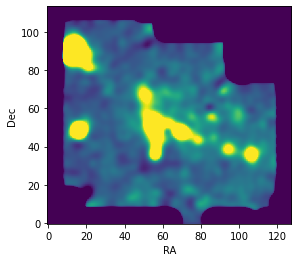

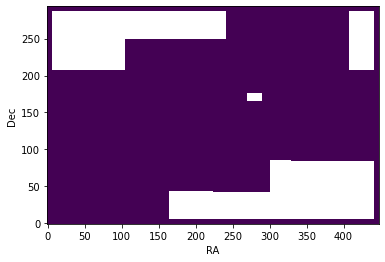

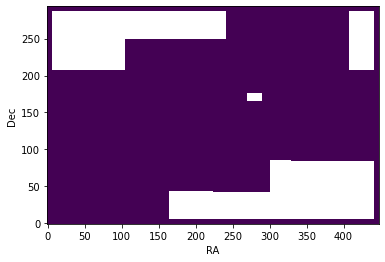

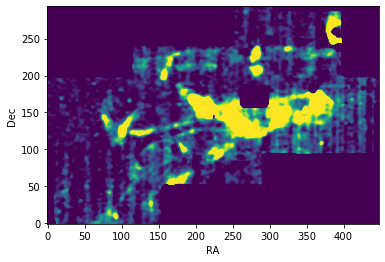

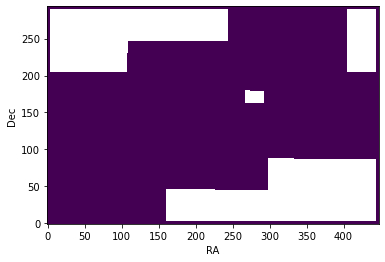

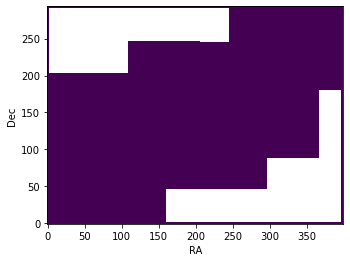

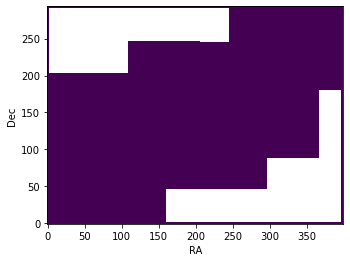

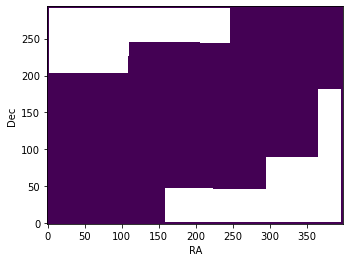

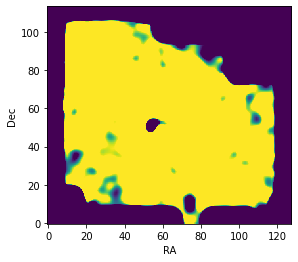

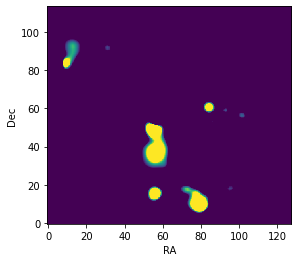

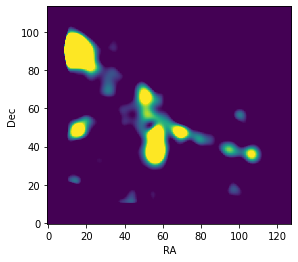

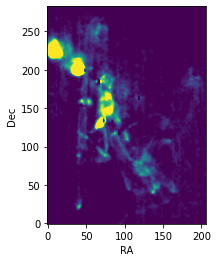

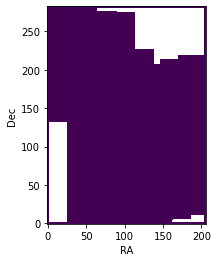

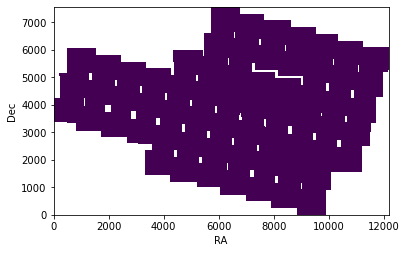

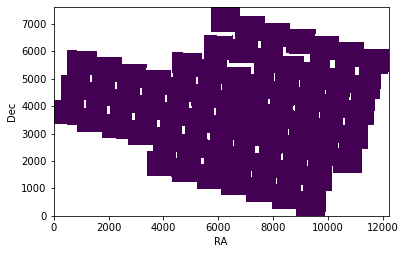

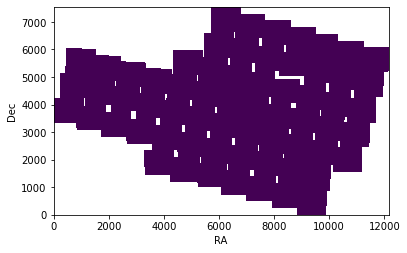

In [4]:
'''
need to do mutual convolutions...it doesn't look like a loop would help much
I really couldn't find a loop, so I just do this mostly by hand...
the basic idea is to run all combinations of convolutions so each image is convolved with each other's psf

here I'm using the function im_conv, which requires the data file name to find the wavelength, the D for the resolution to convolve to, the pixel conversion, and the data that we are convolving
'''
res_str = 'lamflam' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
hdu_conv_list = [] #what we're trying to fill in
# resize = 60. #if trying to adjust size of gaussian convolution

for conving_count,im_data_conving in enumerate(hdu_data_list): #looping through data which we are convolving, changed to hdu_data_list instead of data_cutout_list
    hdu_im_conv = im_data_conving #storing just in case
    count = 0
    
    if conving_count < len(hdu_list)-3:#spitzer
        D = 85 * 1e4 #cm to microns for spitzer, mic is unit of wavelength file
        hdu_im_conv = im_conv(files_data[conving_count], D, hdu_pixtorad_list[conving_count], hdu_im_conv, 'gauss')
        
        
        if files_data[conving_count].find('lh') == True:
            hdu_im_conv = im_conv('n1333_lh_3_SiII_fla', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        elif files_data[conving_count].find('ll') == True:
            hdu_im_conv = im_conv('n1333_ll2_FeII_b', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        #elif files_data[conving_count].find('sh') == True:
        #hdu_im_conv = im_conv('n1333_sh_1_S32', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        elif files_data[conving_count].find('sl') == True:
            hdu_im_conv = im_conv('n1333_sl1_NeII_', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
    elif conving_count >= len(hdu_list)-3: #hubble
        D = 2.4 * 1e6 #m to microns for hubble, mic is unit of wavelength file
        hdu_im_conv = im_conv(files_data[conving_count], D, hdu_pixtorad_list[conving_count], hdu_im_conv, 'gauss')
        hdu_im_conv = im_conv('164_dash', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')              
    count += 1

    #plotting to check
    implot(hdu_im_conv, hdu_header_list[conving_count], False, np.max(hdu_im_conv)/10.)  
    #appending to list for future use
    hdu_conv_list.append(hdu_im_conv)
    
print('convolved!')

In [6]:
#you'll need to set the WCS to be that of the header you're basing this off of...ie the header
# file_start = 'Conv_NoScale_Hub/conv_'+res_str+'_'
res_str = 'unitconverted' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
file_start = 'raw_conv_6_16_22/convol_'+res_str+'_'

conv_path_list = [] #list of paths to the convolved images, can be useful...
#looping through headers and saving images
for count, i in enumerate(hdu_header_list):
    #finding wcs for a given image
    #not done in this version since wcs_cutout_list includes headers
#     w = i #WCS(i) if working from original list of headers instead of cutout wcs's
#     wcs_header = w.to_header()

    #saving each file to some path, conv_path is the path to that file
    if files_data[count].find('FIT') == -1:
        conv_path = fits_saver(hdu_conv_list[count] / hdu_pixtorad_list[count]**2., i, files_data[count], file_start)
        conv_path_list.append(conv_path)
        
    else:
        print(i)
        i['ORGNAME'] = i['ORGNAME'].split('\\')[-1]
        conv_path = fits_saver(hdu_conv_list[count] / hdu_pixtorad_list[count]**2., i, files_data[count][:-4]+'.fits', file_start)
        conv_path_list.append(conv_path)
        
print('saved convolved images!')

0 ../n1333_photometry_ds9.bck.dir/Frame1/n1333_lh_3_FeII_flag400_2_map_fixed.FIT
3 ../n1333_photometry_ds9.bck.dir/Frame15/n1333_sl1_S3_bksub_trim_2_map_fixed1.FIT
8 ../n1333_photometry_ds9.bck.dir/Frame2/n1333_lh_3_S0_flag400_2_map_fixed.FIT
9 ../n1333_photometry_ds9.bck.dir/Frame3/n1333_lh_3_SI_flag400_2_map_fixed.FIT
10 ../n1333_photometry_ds9.bck.dir/Frame4/n1333_lh_3_SiII_flag400_2_map_fixed.FIT
11 ../n1333_photometry_ds9.bck.dir/Frame8/n1333_ll2_S1_bksub_trim_2_map_fixed1.FIT
saved convolved images!


In [ ]:
'''
sample script to run with montage...
see http://montage.ipac.caltech.edu/MontageNotebooks/Mosaic.html
or http://montage.ipac.caltech.edu/MontageNotebooks/ for details
In general, I try to have setup a montage_metadata and diffs folder with temp files
as well as three folders with labels including raw, projected, and corrected
'''
from MontagePy.main import mHdr, mGetHdr, mImgtbl, mProjExec, mImgtbl, mOverlaps, mDiffFitExec, mBgModel, mBgExec, mImgtbl

#the first lines here are just setting up the raw images and projection
size = 0.5 #this is in degrees?
rtn = mHdr('NGC 1333', size, size, "montage_metadata/region.hdr")
rtn = mGetHdr('../n1333_photometry_ds9.bck.dir/Frame14/n1333_sl1_S2_bksub_trim_2_map.fits', 'montage_metadata/fixed_spitzer_hdr.hdr')
rtn = mImgtbl("raw_conv_6_16_22", "montage_metadata/rimages.tbl") #important, no / here for the raw directory...
rtn = mProjExec("raw_conv_6_16_22/", "montage_metadata/rimages.tbl", "montage_metadata/region.hdr", projdir="projected_6_16_22")

#this set of lines is to give an option for background correction
rtn = mImgtbl("corrected_noscale", "montage_metadata/cimages.tbl")
rtn = mOverlaps("montage_metadata/pimages.tbl", "diffs/diffs.tbl")
rtn = mDiffFitExec("projected_noscale", "diffs/diffs.tbl", "montage_metadata/fixed_spitzer_hdr.hdr", "diffs", "diffs/fits.tbl")
rtn = mBgModel("montage_metadata/pimages.tbl", "diffs/fits.tbl", "diffs/corrections.tbl")
rtn = mBgExec("projected_noscale", "montage_metadata/pimages.tbl", "diffs/corrections.tbl", "corrected_noscale")
rtn = mImgtbl("corrected_noscale", "montage_metadata/cimages.tbl")

In [4]:
from scipy.interpolate import CubicSpline

#for de-extincting...should do at an earlier stage for the other lines or just not delete them....
#extracting data
kext_dat = np.genfromtxt('kext_albedo_WD_MW_5.5A_30_D03_delimmod.txt', delimiter=' ', dtype=None, skip_header=80, usecols=range(0,5)) #reading in excel file of extinctions
kext_dat_ascend = sorted(kext_dat, key=lambda x:x[0]) #sorted in ascending order, from small to large lambda

#extracting relevant data and interpolating
lam_kext = [i[0] for i in kext_dat_ascend]
Cext_kext = [i[3] for i in kext_dat_ascend]
vs = CubicSpline(lam_kext, Cext_kext) #interpolating

#checking values
lambdaV = 0.547
lambdaB = 0.4405
print('Rv you should get is 5.5, you get: ', vs(lambdaV) / (vs(lambdaB) - vs(lambdaV))) #checks Rv value


#next part, applying formula we require, which is optical depth as function of lambda, iron 2 ratio
lam_chosen = 0.656 #lambda should be in microns, this is a test
C_ext_Fe2const = vs(1.2570) - vs(1.6440) #constant used in formula


Rv you should get is 5.5, you get:  5.545004128819156


In [5]:
file_list = glob.glob('Montage_results/projected_noscale/hdu0*drz.fits')
file_list = [i.replace('\\', '/') for i in file_list]
print(file_list)
fits_list = [fits.open(i) for i in file_list]
header_list = [i[0].header for i in fits_list]
#hdu_data_list = [i[0].data*(i[0].header['CDELT2']*np.pi/180)**2. for i in fits_list] #if assuming pixels are spitzer scale...
hdu_data_list = [i[0].data*(6.217729758370198e-07)**2. for i in fits_list] #if assuming surf brightness not necessary for montage:D

['Montage_results/projected_noscale/hdu0_conv_lamflam_126build_shift_2_drz.fits', 'Montage_results/projected_noscale/hdu0_conv_lamflam_128build_shift_2_drz.fits', 'Montage_results/projected_noscale/hdu0_conv_lamflam_164build_shift_2_drz.fits']


<ipython-input-6-8ba385240560>:34: RuntimeWarning: invalid value encountered in true_divide
  s = hdu_regridRecovered_list[-3] / hdu_regridRecovered_list[-1] #chosen ratio, 1.26 / 1.64
<ipython-input-6-8ba385240560>:60: RuntimeWarning: invalid value encountered in log
  tau_ext = vs(lam_chosen) / C_ext_Fe2const * np.log(s0 / s) #applying formula
<ipython-input-6-8ba385240560>:97: RuntimeWarning: invalid value encountered in log
  tau_ext = vs(lam_list[n]) / C_ext_Fe2const * np.log(s0 / s) #applying formula


For example, HAlpha:  [[13.65031434 10.84879392 11.34165365 ...         nan         nan
          nan]
 [12.92482456 12.01221699 11.19307402 ...         nan         nan
          nan]
 [12.73349653 10.90642129 12.5975486  ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...  8.59674289  7.71954992
   7.15131616]
 [        nan         nan         nan ...  7.63578186  8.4216467
   9.26953391]
 [        nan         nan         nan ...  8.7378761   7.56775196
   8.74145038]]
1 Montage_results/projected\hdu0_conv_lamflam_n1333_sl1_NeII_bksub_trim_2_map.fits 12.812
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the S

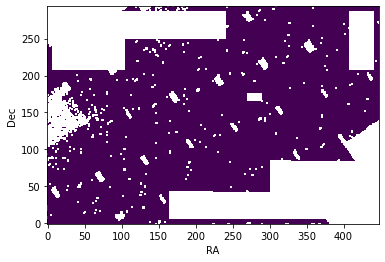

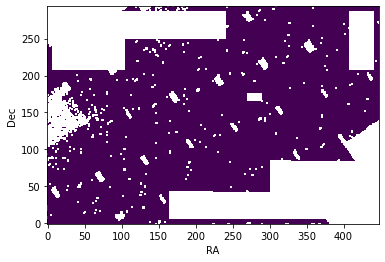

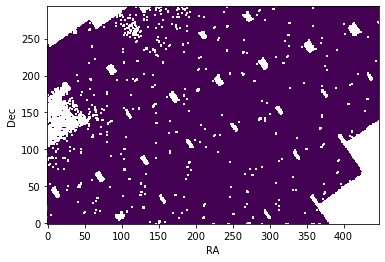

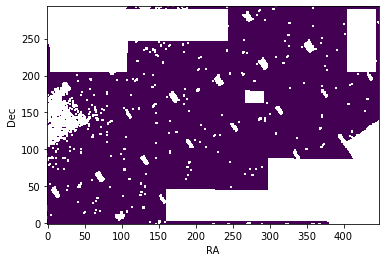

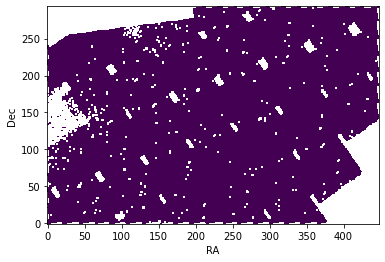

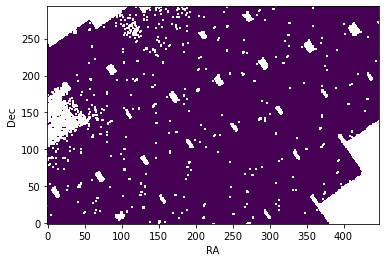

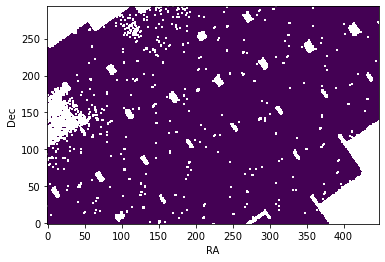

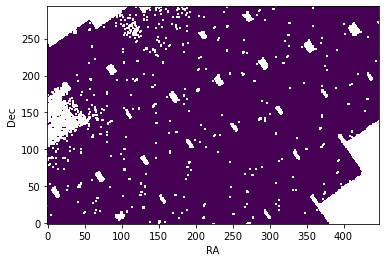

In [6]:
res_str = 'lamflam'

# allowing us to go through without rerunning the conv/regrid stuff
# read in the final regridded images excluding the footprints
placeholderList = glob.glob("Montage_results/projected/*"+ res_str +"*.fits")
placeholderList[:] = [x for x in placeholderList if x.find('area')==-1]

# reordering the placeholder list to match lam_list and files_units
FUSplitList =[]
for i in range(len(files_units)):
    FileUSplit = files_units[i].split('/')
    FUSplitList.append(FileUSplit[-1])

reorderedList = []
for i in FUSplitList:
    for j in placeholderList:
        if j.find(i.split('.')[0]) != -1:
            reorderedList.append(j)
        else:
            continue
# reorderedList.append(placeholderList[0])
# reorderedList.append(placeholderList[1])
# reorderedList.append(placeholderList[2])

#having to rescale the images by the 1.85" pixel scale
hdu_regridRecovered_list = []
header_regridRecovered_list = []
for i in range(len(reorderedList)):
    hdu_regridRecovered_list.append(fits.open(reorderedList[i])[0].data * hdu_pixtorad_list[2]**2.)
    header_regridRecovered_list.append(fits.open(reorderedList[i])[0].header)

    #now computing ratio from our images...
s0 = 2.6 #1.8 #1.26 to 1.64 ratio from EDFs
s = hdu_regridRecovered_list[-3] / hdu_regridRecovered_list[-1] #chosen ratio, 1.26 / 1.64
# s[s>s0]=np.nan #above our chosen ratio, we ignore because would result in negative extinction ?
# s[s<=0.01]=np.nan #AMANDA UPDATE: adjusting range
# s = fits.open('line_ratio_hist/hh_div_moreratios/hh6_ratio126to164_ston_0.2.fits')[0].data

'''NEED TO UPDATE THESE NOISES!!! I THINK THIS IS USED AS THE NOISE CUTOFF......
noises = [3.06806e-19, 1.12685e-18, 2.20903e-18, 1.98002e-18, 2.91648e-18, 5.0651e-18, 5.18521e-18, 
          7.62499e-18, 4.04933e-19, 4.79245e-19, 6.88845e-19, 4.24433e-19, 5.57392e-19, 2.04831e-18, 
          1.0422043e-18, 3.64545e-18] #noises need to be specific for each image, hardcoding them in by taking error from small region in regridded images, error too big trying stddev?

# for i in range(len(hdu_regridRecovered_list)):
#     file = hdu_regridRecovered_list[i]
#     print(file[file<=1*noises[i]])
#     file[file<=1*noises[i]]= np.nan
    #print(file[file<=1*noises[i]])
'''
# noises = [3.06806e-19, 1.12685e-18, 2.20903e-18, 1.98002e-18, 2.91648e-18, 5.0651e-18, 5.18521e-18, 
#           7.62499e-18, 4.04933e-19, 4.79245e-19, 6.88845e-19, 4.24433e-19, 5.57392e-19, 2.04831e-18, 
#           1.0422043e-18, 3.64545e-18] #noises need to be specific for each image, hardcoding them in by taking error from small region in regridded images, error too big trying stddev?

# for i in range(len(hdu_regridRecovered_list)):
#     file = hdu_regridRecovered_list[i]
#     #print(file[file<=1*noises[i]])
#     file[file<=1*noises[i]]= np.nan
#     #print(file[file<=1*noises[i]])

tau_ext = vs(lam_chosen) / C_ext_Fe2const * np.log(s0 / s) #applying formula
print('For example, HAlpha: ', tau_ext)

#now we need wavelengths to get this function fully working...it is a func of wavelength after all...
#unfortunately, our images are awkwardly ordered not by wavelength so...need something to match/extract it
df = pd.read_excel('imglams.xlsx')
cols = df.columns
cols_str = [str(i) for i in df[cols[0]]]

line_list = []
lam_list = []
for name in reorderedList:
    #this finds the loc in the excel file where the image substring matches our image name
    #it then finds the wavelength value corresponding to that loc
    lam =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[1] #lambda in microns
    lam_list.append(lam)
    
    line =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[0] #lambda in microns
    #this is just to clean up the strings before appending
    if name.find('n1333_') != -1:
        line_list.append(line.split('n1333_')[-1])
    else:
        line_list.append(line)


    
#computing tau for each image, then taking image * exp(tau) and saving
file_start = 'Deextincted/montage/deext_'+res_str+'_'
hdu_deextincted_list = []
confirmed_lams = []
confirmed_lines = []
for n in range(len(hdu_regridRecovered_list)):
    if np.shape(hdu_regridRecovered_list[n]) == np.shape(s):
        print(n, reorderedList[n], lam_list[n])
        confirmed_lams.append(lam_list[n])
        confirmed_lines.append(line_list[n])
        
        tau_ext = vs(lam_list[n]) / C_ext_Fe2const * np.log(s0 / s) #applying formula  
        hdu_deextinc = hdu_regridRecovered_list[n] * np.exp(tau_ext)
        implot(hdu_deextinc, wcs.WCS(header_regridRecovered_list[n]), False, np.mean(hdu_deextinc))  
        deext_path = fits_saver(hdu_deextinc, header_regridRecovered_list[n], files_data[n], file_start)
        hdu_deextincted_list.append(hdu_deextinc)


In [41]:
print('vs @ 1.64 mic', vs(lam_list[-1]))

print('C ext for Fe', C_ext_Fe2const)

print('log of a s0=2.6 / s pixel for HH6', np.log(2.6/1.2)) #s0/s for the topmost pixel of HH 6 in the recent montage output

print('vs @ 1.64 mic / C_ext_Fe', vs(lam_list[-1]) / C_ext_Fe2const)

print('tau', vs(lam_list[-1]) / C_ext_Fe2const * np.log(2.6/1.2))

print('exp(tau)', np.exp(1.3))


print('vs @ 547 nm', vs(0.547))

vs @ 1.64 mic 1.185023006126592e-22
C ext for Fe 7.000751815080524e-23
log of a s0=2.6 / s pixel for HH6 0.7731898882334819
vs @ 1.64 mic / C_ext_Fe 1.692708208244005
tau 1.3087848703440796
exp(tau) 3.6692966676192444
vs @ 547 nm 6.715e-22


In [26]:
reorderedList

['Montage_results/projected\\hdu0_conv_lamflam_n1333_lh_3_FeII_flag400_2_map_fixed.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_sl1_NeII_bksub_trim_2_map.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_sl1_S2_bksub_trim_2_map.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_sl1_S3_bksub_trim_2_map_fixed1.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_sl1_S4_bksub_trim_3_map.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_sl2_S5_bksub_trim_2_map.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_sl2_S6_bksub_trim_3_map.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_sl2_S7_bksub_trim_2_map.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_lh_3_S0_flag400_2_map_fixed.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_lh_3_SI_flag400_2_map_fixed.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_n1333_lh_3_SiII_flag400_2_map_fixed.fits',
 'Montage_results/projected\\hdu0_conv_lamflam_

In [27]:
print(lam_list)


'''

IMPORTANT NOTICE: TECHNICALLY LAM_LIST IS 16 ELEMENTS
WHILE EVERYTHING ELSE IS 15.......
THERE IS SOMETHING MISMATCHING HERE BUT NOT SIGNIFICANTLY IMPACTING, DOUBLE CHECK ALL THE LOOPS AND INDEXING!
...I changed it for now where lam_list loop is based on files_data, but it looks prettier with files_units...weird...

'''



[26.0, 12.812, 12.279, 9.665, 8.025, 6.91, 6.109, 5.511, 28.219, 25.249, 34.814, 17.936, 1.25162, 1.28366, 1.64501]


'\n\nIMPORTANT NOTICE: TECHNICALLY LAM_LIST IS 16 ELEMENTS\nWHILE EVERYTHING ELSE IS 15.......\nTHERE IS SOMETHING MISMATCHING HERE BUT NOT SIGNIFICANTLY IMPACTING, DOUBLE CHECK ALL THE LOOPS AND INDEXING!\n...I changed it for now where lam_list loop is based on files_data, but it looks prettier with files_units...weird...\n\n'

In [11]:
R_Fe = vs(0.547) / C_ext_Fe2const
print(R_Fe)
tau_ext = vs(0.547) / C_ext_Fe2const * np.log(s0 / s)
taupath = fits_saver(tau_ext, header_regridRecovered_list[-1], 'Deextintcted/montage/tau_'+str(0.547)+'.fits', file_start)
# avpath = fits_saver(2.5 * np.log10(np.exp(1.)) * tau_ext, wcs_cutout_list[regrid_ind], 'Deextintcted/Av_'+str(0.547)+'.fits', file_start)
avpath = fits_saver(2.5 * R_Fe * np.log10(2.6 / s), header_regridRecovered_list[-1], 'Deextintcted/montage/Av_'+str(0.547)+'.fits', file_start)

hstpath = fits_saver(hdu_regridRecovered_list[-3], header_regridRecovered_list[-3], 'Deextincted/montage/126_for_dext.fits', file_start)
hstpath = fits_saver(hdu_regridRecovered_list[-1], header_regridRecovered_list[-1], 'Deextincted/montage/164_for_dext.fits', file_start)

ratiopath = fits_saver(s, header_regridRecovered_list[-1], 'Deextincted/montage/126_164_for_dext.fits', file_start)
ratiopath = fits_saver(s0/s, header_regridRecovered_list[-1], 'Deextintcted/montage/s0_s_ratio_'+str(lam_list[n])+'.fits', file_start)
ratiopath = fits_saver(np.log(s0/s), header_regridRecovered_list[-1], 'Deextintcted/montage/ln_s0_s_ratio_'+str(lam_list[n])+'.fits', file_start)

taupath = fits_saver(tau_ext, header_regridRecovered_list[-1], 'Deextintcted/montage/tau_'+str(lam_list[n])+'.fits', file_start)
taupath = fits_saver(np.exp(tau_ext), header_regridRecovered_list[-1], 'Deextintcted/montage/exp_tau_'+str(lam_list[n])+'.fits', file_start)

9.591826959977388


<ipython-input-11-a952b290cb6e>:3: RuntimeWarning: invalid value encountered in log
  tau_ext = vs(0.547) / C_ext_Fe2const * np.log(s0 / s)
<ipython-input-11-a952b290cb6e>:6: RuntimeWarning: invalid value encountered in log10
  avpath = fits_saver(2.5 * R_Fe * np.log10(2.6 / s), header_regridRecovered_list[-1], 'Deextintcted/montage/Av_'+str(0.547)+'.fits', file_start)
<ipython-input-11-a952b290cb6e>:13: RuntimeWarning: invalid value encountered in log
  ratiopath = fits_saver(np.log(s0/s), header_regridRecovered_list[-1], 'Deextintcted/montage/ln_s0_s_ratio_'+str(lam_list[n])+'.fits', file_start)


In [ ]:
#purpose of this cell is to deal with apertures
#for hh6, refer to http://articles.adsabs.harvard.edu/pdf/1991ApJ...371..237C for aperture examples (fig. 5)

#possibly could do EDFs, possibly dividing the hubble images to determine extinction...maybe should do separately?
#if you want to divide two of the data files, can do so like
#data_ratio = np.divide(array, hdu1_conv_scaled, out=np.zeros_like(array), where=hdu1_conv_scaled!=0) #need to do np.divide to guarantee we get no divide by zero issue...

#knots 1 ... 7
coords_list = [[(278., 225.), (2, 2)], 
              [(281, 227), (2, 2)],
              [(279, 230), (2, 2)],
              [(283, 232), (2, 2)],
              [(283, 233), (2, 2)],
              [(281, 235), (2, 2)],
              [(285, 237), (2, 2)],
              ]

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Lines', 'Lambda'] #columns
for num in range(len(coords_list)):
    column_names.append('Knot'+str(num))

#creating dataframe and filling in the first two columns from the lists we just made
df = pd.DataFrame(columns = column_names)
df['Lines'] = confirmed_lines
df['Lambda'] = confirmed_lams


#looping through images (wavelengths)
for i in range(len(hdu_deextincted_list)):
    #looping through knots
    for j in range(len(coords_list)):
        #unpacking coords
        position = coords_list[j][0]
        size = coords_list[j][1]
        
        #cutting out coordinates    
        cutout = Cutout2D(hdu_deextincted_list[i], position, size, wcs = wcs.WCS(header_regridRecovered_list[-1]))
        datacut = cutout.data
        wcscut = cutout.wcs
        
        knot_flux = np.nansum(datacut) #computing the flux of the cutout for each knot
        #saving fluxes in a table
        df['Knot'+str(j)].at[i] = knot_flux
        
        
#         #plotting image
#         implot(datacut, wcscut, False, np.max(datacut))

# print(df.sort_values(by=['Lambda'], ascending=True)) #if you want to sort by wavelength from low to high lambdas
print(df)

#saving as excel file for use in next code
excel_savepath = '../../Model Code and Observations/HH6_Adam/Dered_Fluxes_montage.xlsx'
# !conda install --yes --prefix {sys.prefix} openpyxl #IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
df.to_excel(excel_savepath, index=False)
print('saved data!')

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
coord0 and lam=1.251

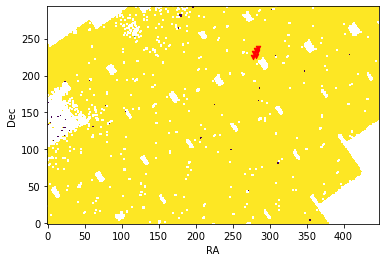

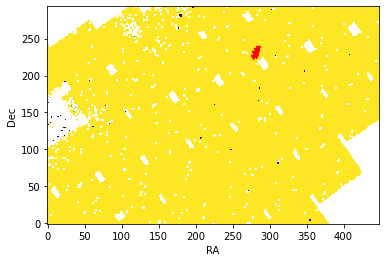

In [12]:
#knots 1 ... 7
coords_list = [[(278., 225.), (2, 2)], 
              [(281, 227), (2, 2)],
              [(279, 230), (2, 2)],
              [(283, 232), (2, 2)],
              [(283, 233), (2, 2)],
              [(281, 235), (2, 2)],
              [(285, 237), (2, 2)],
              ]

#looping through images (wavelengths)
for i in [-3, -1]:
    #looping through knots
    implot(hdu_deextincted_list[i], wcs.WCS(header_regridRecovered_list[-1]), False, 1e-16)
    
    for j in range(len(coords_list)):
        print('coord'+str(j)+' and lam='+str(lam_list[i]))
        
        #unpacking coords
        position = coords_list[j][0]
        size = coords_list[j][1]
        
        plt.scatter(position[0], position[1], marker='v', color='red', s=20)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

(0.0, 20.0)

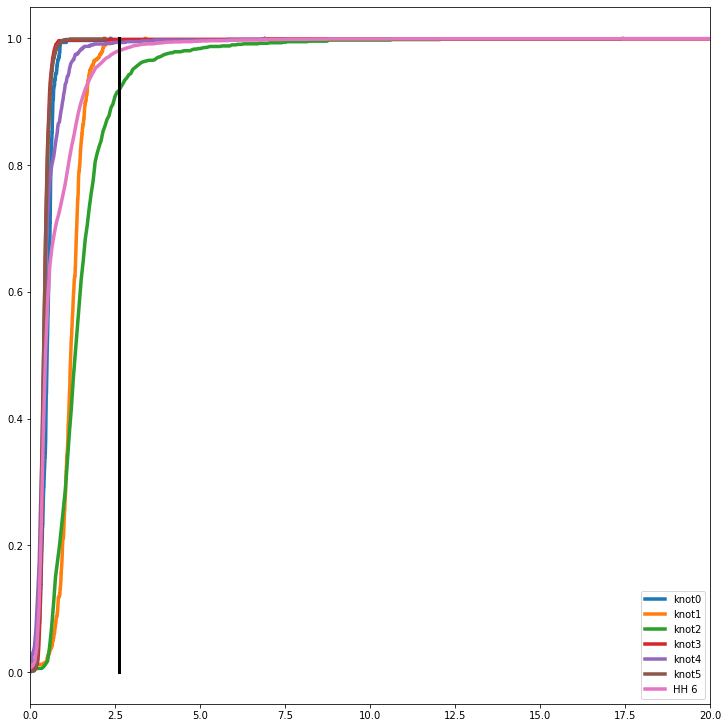

In [18]:
#locating turnoff of EDF as check for my code and images...

def edf_calc(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / (n)
    
    #alt method from https://stackoverflow.com/questions/42147206/normalizing-cdf-in-python
    num_bins = 2500
    x = data[~np.isnan(np.sort(data))]
    counts, bin_edges = np.histogram(x, bins=num_bins, range=(np.nanmin(x), np.nanmax(x)), density=True)
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate and plot CDF of sample 
    cdf = np.cumsum(counts)
    scale = 1.0/cdf[-1]
    norm_cdf = scale * cdf
    
    return(center, norm_cdf)



def file_open(file):
    hdu1 = fits.open(file)  #import image
    w = wcs.WCS(hdu1[0].header)   #get wcs coords
    data = hdu1[0].data  #getting data from hdu
    hdu1.close()

    return w, data


# file = 'HH6/regrid_hub_longexp_1.26_to_1.64_0.0_ston_0.8.fits'
perc=0.2
# file = 'line_ratio_hist/hh_div/regrid_hh6_ston_'+str(perc)+'.fits'
# w, data = file_open(file) #setting to header_regridrRecovered_list, hdu_regridRecovered

# coords_list = [[(50., 65.), (40, 40)], [(97, 75), (40, 40)],[(100, 119), (47, 47)],[(120, 167), (47, 47)],[(167, 115), (44, 44)],[(175, 163), (40, 40)],[(220, 167), (52, 52)],]
coords_list = [[(49, 63), (18, 18)], 
               [(95, 72), (17, 29)],
               [(103, 116), (35, 34)],
               [(166, 111), (38, 38)],
               [(175, 163), (30, 29)],
               [(223, 165), (34, 37)],]

hh6_concat = [] #initializing list to join all the hh6 knots

fig, (ax1) = plt.subplots(1, figsize=(10,10), sharex=True, constrained_layout=True)

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(s, position, size, wcs = wcs.WCS(header_regridRecovered_list[-3]))
    datacut = cutout.data
    wcscut = cutout.wcs


    #     flatting data and plotting EDF
    flat_data = np.sort(datacut.flatten())
    hh6_concat = np.concatenate((hh6_concat, flat_data), axis=None)

    xedf, yedf = edf_calc(flat_data)
    # plt.figure(111)
    plot_color = ax1.plot(xedf, yedf, label =  'knot'+str(i), linewidth = 3.5, linestyle='-')
    # print(plot_color.get_facecolor())
    
xedf, yedf = edf_calc(hh6_concat)
plot_color = ax1.plot(xedf, yedf, label =  'HH 6', linewidth = 3.5, linestyle='-')
ax1.legend()
ax1.plot([2.6, 2.6], [0,1], label ='This Work (2.6)', color='black', linestyle='-', linewidth=3)

plt.xlim(0, 20)
